## Install package

In [1]:
#!pip install segmentation-models-pytorch lightning albumentations
#!pip install torchinfo

In [2]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch import nn
from torchinfo import summary

#import torch
#import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
#import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau
#from torch.cuda.amp import GradScaler, autocast

In [3]:
DATA_DIR = "./data/"

x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "train_masks")

x_valid_dir = os.path.join(DATA_DIR, "val")
y_valid_dir = os.path.join(DATA_DIR, "val_masks")

x_test_dir = os.path.join(DATA_DIR, "test")
y_test_dir = os.path.join(DATA_DIR, "test_masks")

classes = ["background", "grass", "densetree"]  # Define class names

## Dataloader

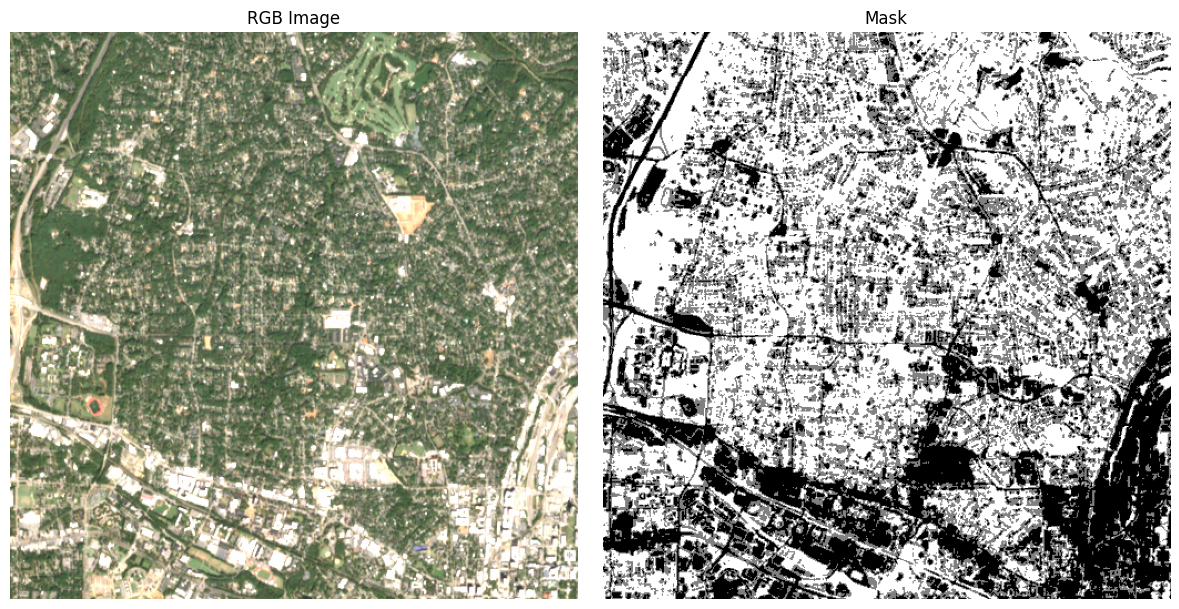

In [4]:
class MultiClassDataset(Dataset):
    def __init__(self, x_dir, y_dir, classes, transform=None):
        """
        Args:
            x_dir (str): Path to the directory containing input images.
            y_dir (str): Path to the directory containing masks (multi-class).
            classes (list): List of class names.
            transform (callable, optional): Transform to apply to both image and mask.
        """
        self.x_dir = x_dir
        self.y_dir = y_dir
        self.classes = classes
        self.num_classes = len(classes)
        self.transform = transform
        self.x_paths = sorted(os.listdir(x_dir))
        self.y_paths = sorted(os.listdir(y_dir))

    def __len__(self):
        return len(self.x_paths)

    def __getitem__(self, index):
        # Load image and mask
        img_path = os.path.join(self.x_dir, self.x_paths[index])
        mask_path = os.path.join(self.y_dir, self.y_paths[index])

        image = Image.open(img_path)  # Load image without conversion
        mask = Image.open(mask_path)  # Load mask without conversion

        # Convert to NumPy arrays
        image = np.array(image, dtype=np.float32) / 255.0  # Normalize image
        mask = np.array(mask, dtype=np.int64)  # Ensure mask is integer type

        # Apply transform if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Ensure image and mask are PyTorch tensors
        if isinstance(image, np.ndarray):
            if len(image.shape) == 3:  # Handle RGB images
                image = torch.from_numpy(image).permute(2, 0, 1)  # Convert HWC (height, width, col) to CHW
            else:  # Handle single-channel images
                image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension

        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask)  # Mask remains H x W

        return image, mask


# Function to visualize an image and its corresponding mask
def visualize_image_and_mask(dataset, index=0):
    # Load the RGB image and mask from the dataset
    image, mask = dataset[index]

    # Convert tensors to NumPy arrays (if applicable)
    if hasattr(image, 'numpy'):
        image = image.numpy().transpose(1, 2, 0)  # Convert CHW to HWC format
    if hasattr(mask, 'numpy'):
        mask = mask.numpy()

    # Plot the image and mask side by side
    plt.figure(figsize=(12, 6))

    # Plot the RGB image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("RGB Image")
    plt.axis("off")

    # Plot the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")  # Use colormap for multi-class mask
    plt.title("Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Function to define augmentations
def get_augmentations():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),
        #A.PadIfNeeded(min_height=512, min_width=512, always_apply=True),
        #A.RandomCrop(height=512, width=512, always_apply=True),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        ToTensorV2(),
    ]
    return A.Compose(train_transform)

def no_augmentations():
    return A.Compose([ToTensorV2()])

# Example usage
# Assuming x_train_dir and y_train_dir are directories with images and masks
dataset = MultiClassDataset(x_train_dir, y_train_dir, classes, transform=no_augmentations())
visualize_image_and_mask(dataset, index=0)

# Visualizing the same image with different random transforms
#for i in range(3):
#    visualize_image_and_mask(dataset, index=i)


In [5]:
train_dataset = MultiClassDataset(
    x_train_dir,
    y_train_dir,
    classes,
    #transform=no_augmentations(),
)

val_dataset = MultiClassDataset(
    x_train_dir,
    y_train_dir,
    classes,
    #transform=no_augmentations(),
)

test_dataset = MultiClassDataset(
    x_train_dir,
    y_train_dir,
    classes,
    #transform=no_augmentations(),
)

# Change to > 0 if not on Windows machine
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [6]:
def describe_loader(loader_type):
    print("batch size: ",loader_type.batch_size)
    print("shape: ", loader_type.dataset[0][0].shape, loader_type.dataset[0][1].shape)
    print(np.unique(loader_type.dataset[0][1]))
    print("number of images: ", len(loader_type.dataset))
    print("classes: ", loader_type.dataset.classes)

print("------------train------------")
describe_loader(train_loader)
print("------------val------------")
describe_loader(val_loader)
print("------------test------------")
describe_loader(test_loader)

------------train------------
batch size:  32
shape:  torch.Size([3, 512, 512]) torch.Size([512, 512])
[0 1 2]
number of images:  10
classes:  ['background', 'grass', 'densetree']
------------val------------
batch size:  32
shape:  torch.Size([3, 512, 512]) torch.Size([512, 512])
[0 1 2]
number of images:  10
classes:  ['background', 'grass', 'densetree']
------------test------------
batch size:  32
shape:  torch.Size([3, 512, 512]) torch.Size([512, 512])
[0 1 2]
number of images:  10
classes:  ['background', 'grass', 'densetree']


## Model definition

In [7]:
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'grass', 'densetree']
ACTIVATION = 'sigmoid'
DEVICE = 'cpu'

# B,C,H,W = batch size, channels, height, width
# eg. (1, 3, 256, 256) = 1 image, 3 channels (RGB), 256x256 pixels

# mask should be (B, H, W)

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels=3,                 # Input image channels (e.g., RGB)
)
summary(model, (1, 3, 256, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
DeepLabV3Plus                                           [1, 3, 256, 256]          --
├─ResNetEncoder: 1-1                                    [1, 3, 256, 256]          --
│    └─Conv2d: 2-1                                      [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                                 [1, 64, 128, 128]         128
│    └─ReLU: 2-3                                        [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                                   [1, 64, 64, 64]           --
│    └─Sequential: 2-5                                  [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                             [1, 64, 64, 64]           73,984
│    │    └─BasicBlock: 3-2                             [1, 64, 64, 64]           73,984
│    └─Sequential: 2-6                                  [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-3                     

### Not used

In [8]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# import segmentation_models_pytorch as smp

# # Hyperparameters
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# epochs = 5
# lr = 1e-4
# batch_size = 16
# num_classes = 3


# def train_unet(model, train_loader, val_loader):
#     # Define loss and optimizer
#     loss_fn = nn.CrossEntropyLoss()  # For multi-class segmentation
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     # To store loss history
#     history = {'train_loss': [], 'val_loss': []}

#     # Training loop
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0

#         # Loop through training batches
#         for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
#             images, masks = batch
#             images, masks = images.to(device), masks.to(device)

#             # Forward pass
#             outputs = model(images)

#             # Calculate loss
#             loss = loss_fn(outputs, masks.long())
#             train_loss += loss.item()

#             # Backward pass and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         # Validation loop
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
#                 images, masks = batch
#                 images, masks = images.to(device), masks.to(device)

#                 # Forward pass
#                 outputs = model(images)

#                 # Calculate loss
#                 loss = loss_fn(outputs, masks.long())
#                 val_loss += loss.item()

#         train_loss /= len(train_loader)
#         val_loss /= len(val_loader)

#         # Store losses
#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)

#         print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

#     print("Training Complete")
#     return model, history

# # Save the model
# def save_model(model, path="unet_model.pth"):
#     torch.save(model.state_dict(), path)

# # Load the model
# def load_model(model, path="unet_model.pth"):
#     model.load_state_dict(torch.load(path, map_location=device))
#     model.to(device)
#     return model

# # Evaluate on test_loader
# def evaluate_model(model, test_loader):
#     model.eval()
#     test_loss = 0
#     loss_fn = nn.CrossEntropyLoss()

#     with torch.no_grad():
#         for images, masks in tqdm(test_loader, desc="Evaluating on Test Data"):
#             images, masks = images.to(device), masks.to(device)
#             outputs = model(images)
#             loss = loss_fn(outputs, masks.long())
#             test_loss += loss.item()

#     test_loss /= len(test_loader)
#     print(f"Test Loss: {test_loss:.4f}")

# # Example usage
# trained_model, history = train_unet(model, train_loader, val_loader)

### Model train

In [9]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20
lr = 1e-4
batch_size = 16
num_classes = 3

# Training Function
def train_unet(model, train_loader, val_loader):
    # Define loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # To store loss and metric history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_metrics': {'iou': [], 'f1': [], 'accuracy': [], 'recall': []},
        'val_metrics': {'iou': [], 'f1': [], 'accuracy': [], 'recall': []},
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_stats = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}

        # Training loop
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks.long())
            train_loss += loss.item()

            optimizer.zero_grad()

            # Compute stats for each batch
            preds = torch.argmax(outputs, dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(preds.int(), masks.int(), 
                                                   mode="multiclass", 
                                                   num_classes=num_classes)
            train_stats['tp'] += tp.sum()
            train_stats['fp'] += fp.sum()
            train_stats['fn'] += fn.sum()
            train_stats['tn'] += tn.sum()

        # Calculate training metrics
        iou = smp.metrics.iou_score(train_stats['tp'], train_stats['fp'], 
                                    train_stats['fn'], train_stats['tn'], reduction="micro")
        f1 = smp.metrics.f1_score(train_stats['tp'], train_stats['fp'], 
                                    train_stats['fn'], train_stats['tn'], reduction="micro")
        accuracy = smp.metrics.accuracy(train_stats['tp'], train_stats['fp'], 
                                    train_stats['fn'], train_stats['tn'], reduction="macro")
        recall = smp.metrics.recall(train_stats['tp'], train_stats['fp'], 
                                    train_stats['fn'], train_stats['tn'], reduction="micro")

        # Log metrics
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        history['train_metrics']['iou'].append(iou)
        history['train_metrics']['f1'].append(f1)
        history['train_metrics']['accuracy'].append(accuracy)
        history['train_metrics']['recall'].append(recall)

        # Validation loop
        model.eval()
        val_loss = 0
        val_stats = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks.long())
                val_loss += loss.item()

                # Compute stats for each batch
                preds = torch.argmax(outputs, dim=1)
                tp, fp, fn, tn = smp.metrics.get_stats(preds.int(), masks.int(), 
                                                       mode="multiclass", 
                                                       num_classes=num_classes)
                val_stats['tp'] += tp.sum()
                val_stats['fp'] += fp.sum()
                val_stats['fn'] += fn.sum()
                val_stats['tn'] += tn.sum()

        # Calculate validation metrics
        iou = smp.metrics.iou_score(val_stats['tp'], val_stats['fp'], 
                                    val_stats['fn'], val_stats['tn'], reduction="micro")
        f1 = smp.metrics.f1_score(val_stats['tp'], val_stats['fp'], 
                                    val_stats['fn'], val_stats['tn'], reduction="micro")
        accuracy = smp.metrics.accuracy(val_stats['tp'], val_stats['fp'], 
                                    val_stats['fn'], val_stats['tn'], reduction="macro")
        recall = smp.metrics.recall(val_stats['tp'], val_stats['fp'], 
                                    val_stats['fn'], val_stats['tn'], reduction="micro")

        # Log metrics
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_metrics']['iou'].append(iou)
        history['val_metrics']['f1'].append(f1)
        history['val_metrics']['accuracy'].append(accuracy)
        history['val_metrics']['recall'].append(recall)

        # Adjust learning rate
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Metrics: IoU: {iou:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}")
        print(f"Validation Metrics: IoU: {iou:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}")

    print("Training Complete")
    return model, history


# Save and Load Functions
def save_model(model, path="unet_model.pth"):
    torch.save(model.state_dict(), path)

def load_model(model, path="unet_model.pth"):
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    return model

# Evaluate Model with Metrics
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    test_stats = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating on Test Data"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = loss_fn(outputs, masks.long())
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(preds.int(), masks.int(), 
                                                   mode="multiclass", num_classes=num_classes)
            test_stats['tp'] += tp.sum()
            test_stats['fp'] += fp.sum()
            test_stats['fn'] += fn.sum()
            test_stats['tn'] += tn.sum()

    # Calculate test metrics
    iou = smp.metrics.iou_score(test_stats['tp'], test_stats['fp'], 
                                test_stats['fn'], test_stats['tn'], reduction="micro")
    f1 = smp.metrics.f1_score(test_stats['tp'], test_stats['fp'], 
                                test_stats['fn'], test_stats['tn'], reduction="micro")
    accuracy = smp.metrics.accuracy(test_stats['tp'], test_stats['fp'], 
                                test_stats['fn'], test_stats['tn'], reduction="macro")
    recall = smp.metrics.recall(test_stats['tp'], test_stats['fp'], 
                                test_stats['fn'], test_stats['tn'], reduction="micro")

    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Metrics: IoU: {iou:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}")


In [10]:
trained_model, history = train_unet(model, train_loader, val_loader)

Epoch 1/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 1, Train Loss: 1.1033, Val Loss: 1.0989
Train Metrics: IoU: 0.1989, F1: 0.3318, Accuracy: 0.5545, Recall: 0.3318
Validation Metrics: IoU: 0.1989, F1: 0.3318, Accuracy: 0.5545, Recall: 0.3318


Epoch 2/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Epoch 2, Train Loss: 1.1023, Val Loss: 1.0984
Train Metrics: IoU: 0.1987, F1: 0.3315, Accuracy: 0.5544, Recall: 0.3315
Validation Metrics: IoU: 0.1987, F1: 0.3315, Accuracy: 0.5544, Recall: 0.3315


Epoch 3/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 3, Train Loss: 1.1023, Val Loss: 1.0980
Train Metrics: IoU: 0.1992, F1: 0.3322, Accuracy: 0.5548, Recall: 0.3322
Validation Metrics: IoU: 0.1992, F1: 0.3322, Accuracy: 0.5548, Recall: 0.3322


Epoch 4/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Epoch 4, Train Loss: 1.1026, Val Loss: 1.0976
Train Metrics: IoU: 0.2022, F1: 0.3364, Accuracy: 0.5576, Recall: 0.3364
Validation Metrics: IoU: 0.2022, F1: 0.3364, Accuracy: 0.5576, Recall: 0.3364


Epoch 5/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Epoch 5, Train Loss: 1.1024, Val Loss: 1.0973
Train Metrics: IoU: 0.2131, F1: 0.3513, Accuracy: 0.5675, Recall: 0.3513
Validation Metrics: IoU: 0.2131, F1: 0.3513, Accuracy: 0.5675, Recall: 0.3513


Epoch 6/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Epoch 6, Train Loss: 1.1027, Val Loss: 1.0970
Train Metrics: IoU: 0.2338, F1: 0.3789, Accuracy: 0.5860, Recall: 0.3789
Validation Metrics: IoU: 0.2338, F1: 0.3789, Accuracy: 0.5860, Recall: 0.3789


Epoch 7/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Epoch 7, Train Loss: 1.1024, Val Loss: 1.0968
Train Metrics: IoU: 0.2564, F1: 0.4081, Accuracy: 0.6054, Recall: 0.4081
Validation Metrics: IoU: 0.2564, F1: 0.4081, Accuracy: 0.6054, Recall: 0.4081


Epoch 8/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Epoch 8, Train Loss: 1.1025, Val Loss: 1.0965
Train Metrics: IoU: 0.2699, F1: 0.4251, Accuracy: 0.6167, Recall: 0.4251
Validation Metrics: IoU: 0.2699, F1: 0.4251, Accuracy: 0.6167, Recall: 0.4251


Epoch 9/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Epoch 9, Train Loss: 1.1027, Val Loss: 1.0963
Train Metrics: IoU: 0.2755, F1: 0.4320, Accuracy: 0.6214, Recall: 0.4320
Validation Metrics: IoU: 0.2755, F1: 0.4320, Accuracy: 0.6214, Recall: 0.4320


Epoch 10/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Epoch 10, Train Loss: 1.1031, Val Loss: 1.0960
Train Metrics: IoU: 0.2786, F1: 0.4357, Accuracy: 0.6238, Recall: 0.4357
Validation Metrics: IoU: 0.2786, F1: 0.4357, Accuracy: 0.6238, Recall: 0.4357


Epoch 11/20 [Validation]: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Epoch 11, Train Loss: 1.1028, Val Loss: 1.0958
Train Metrics: IoU: 0.2786, F1: 0.4358, Accuracy: 0.6239, Recall: 0.4358
Validation Metrics: IoU: 0.2786, F1: 0.4358, Accuracy: 0.6239, Recall: 0.4358


Epoch 12/20 [Validation]: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 12, Train Loss: 1.1026, Val Loss: 1.0956
Train Metrics: IoU: 0.2786, F1: 0.4358, Accuracy: 0.6239, Recall: 0.4358
Validation Metrics: IoU: 0.2786, F1: 0.4358, Accuracy: 0.6239, Recall: 0.4358


Epoch 13/20 [Validation]: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 13, Train Loss: 1.1024, Val Loss: 1.0954
Train Metrics: IoU: 0.2784, F1: 0.4355, Accuracy: 0.6237, Recall: 0.4355
Validation Metrics: IoU: 0.2784, F1: 0.4355, Accuracy: 0.6237, Recall: 0.4355


Epoch 14/20 [Validation]: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 14, Train Loss: 1.1028, Val Loss: 1.0953
Train Metrics: IoU: 0.2781, F1: 0.4352, Accuracy: 0.6234, Recall: 0.4352
Validation Metrics: IoU: 0.2781, F1: 0.4352, Accuracy: 0.6234, Recall: 0.4352


Epoch 15/20 [Validation]: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Epoch 15, Train Loss: 1.1025, Val Loss: 1.0951
Train Metrics: IoU: 0.2781, F1: 0.4352, Accuracy: 0.6234, Recall: 0.4352
Validation Metrics: IoU: 0.2781, F1: 0.4352, Accuracy: 0.6234, Recall: 0.4352


Epoch 16/20 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Epoch 16, Train Loss: 1.1025, Val Loss: 1.0950
Train Metrics: IoU: 0.2782, F1: 0.4353, Accuracy: 0.6235, Recall: 0.4353
Validation Metrics: IoU: 0.2782, F1: 0.4353, Accuracy: 0.6235, Recall: 0.4353


Epoch 17/20 [Validation]: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Epoch 17, Train Loss: 1.1025, Val Loss: 1.0949
Train Metrics: IoU: 0.2777, F1: 0.4347, Accuracy: 0.6232, Recall: 0.4347
Validation Metrics: IoU: 0.2777, F1: 0.4347, Accuracy: 0.6232, Recall: 0.4347


Epoch 18/20 [Validation]: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Epoch 18, Train Loss: 1.1031, Val Loss: 1.0949
Train Metrics: IoU: 0.2769, F1: 0.4337, Accuracy: 0.6225, Recall: 0.4337
Validation Metrics: IoU: 0.2769, F1: 0.4337, Accuracy: 0.6225, Recall: 0.4337


Epoch 19/20 [Validation]: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


Epoch 19, Train Loss: 1.1028, Val Loss: 1.0948
Train Metrics: IoU: 0.2751, F1: 0.4314, Accuracy: 0.6210, Recall: 0.4314
Validation Metrics: IoU: 0.2751, F1: 0.4314, Accuracy: 0.6210, Recall: 0.4314


Epoch 20/20 [Validation]: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


Epoch 20, Train Loss: 1.1029, Val Loss: 1.0948
Train Metrics: IoU: 0.2734, F1: 0.4294, Accuracy: 0.6196, Recall: 0.4294
Validation Metrics: IoU: 0.2734, F1: 0.4294, Accuracy: 0.6196, Recall: 0.4294
Training Complete


In [11]:
save_model(trained_model, "unet_model.pth")
model = load_model(model, "unet_model.pth")
evaluate_model(model, test_loader)

Evaluating on Test Data: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]

Test Loss: 1.0948
Test Metrics: IoU: 0.2734, F1: 0.4294, Accuracy: 0.6196, Recall: 0.4294


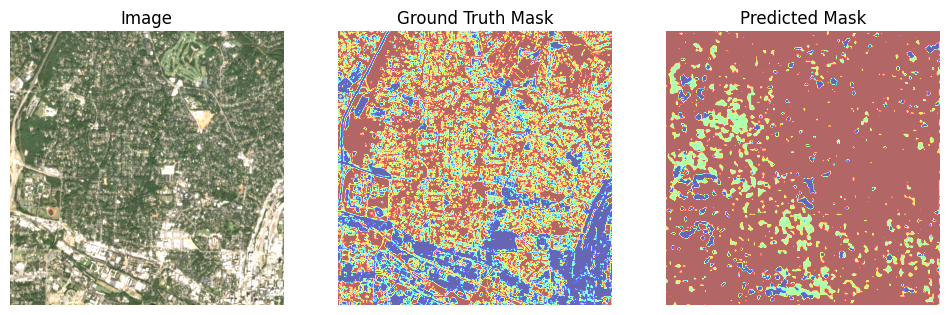

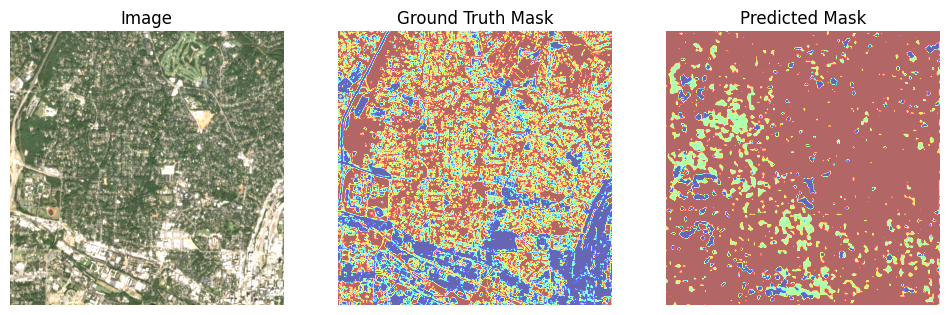

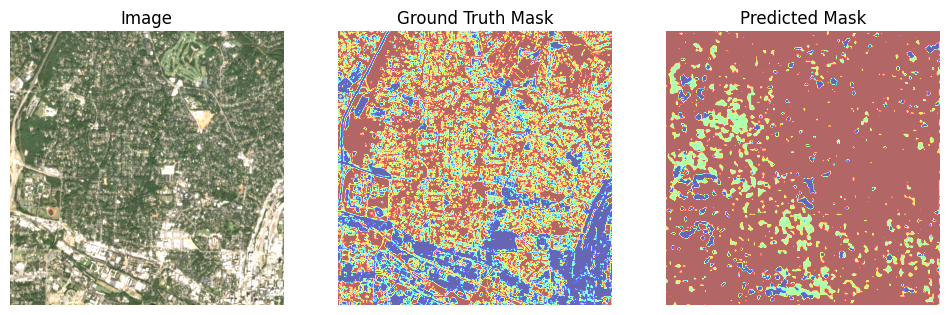

In [12]:
# Display images, generated segmentations, and masks
def display_segmentation(model, data_loader, num_images=3):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return

                image = images[i].cpu().permute(1, 2, 0).numpy()
                mask = masks[i].cpu().numpy()
                pred = preds[i].cpu().numpy()

                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 3, 1)
                plt.title("Image")
                plt.imshow(image)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth Mask")
                plt.imshow(mask, cmap="jet", alpha=0.6)
                plt.axis('off')
                #print(np.unique(mask))

                plt.subplot(1, 3, 3)
                plt.title("Predicted Mask")
                plt.imshow(pred, cmap="jet", alpha=0.6)
                plt.axis('off')
                #print(np.unique(pred))

                plt.show()

                images_shown += 1

display_segmentation(model, test_loader)